In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

from nyaggle.experiment import run_experiment

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v3_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v3_test_df.parquet')

In [3]:
train_label = pd.read_csv('../train_label.csv')
train_log = pd.read_csv('../train_log.csv')
test_session = pd.read_csv('../test_session.csv')
test_log = pd.read_csv('../test_log.csv')
image_embeddings = pd.read_parquet('../image_embeddings.parquet')

In [7]:
"""
# MultiuHotEncodingはメモリが足りない　
from sklearn.preprocessing import MultiLabelBinarizer
# session_idごとにyad_noのリストを作成
session_yadno = train_log.groupby('session_id')['yad_no'].apply(list)
# MultiLabelBinarizerのインスタンスを作成
mlb = MultiLabelBinarizer()
# MultiHotEncodingを実施
multi_hot_encoded = mlb.fit_transform(session_yadno)
# 結果をDataFrameに変換
multi_hot_df = pd.DataFrame(multi_hot_encoded, columns=mlb.classes_, index=session_yadno.index)
# 結果の最初の数行を表示
multi_hot_df.head()
"""

,2,3,4,5,6,7,9,10,11,12,...,13796,13797,13798,13799,13800,13801,13803,13804,13805,13806
session_id,,,,,,,,,,,,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000ca043ed437a1472c9d1d154eb49b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000d4835cf113316fe447e2f80ba1c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000fcda1ae1b2f431e55a7075d1f500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104bdffaaad1a1e0a9ebacf585f33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF

In [4]:
# train_logとtest_logを結合
log_df = pd.concat([train_log, test_log], sort=False)

# session_idごとにyad_noのリストを作成
session_yadno = log_df.groupby('session_id')['yad_no'].apply(list)
# session_yadnoがシリーズであるため、これをデータフレームに変換
session_yadno_df = session_yadno.reset_index(name='yadno_list')
session_yadno_df

,session_id,yadno_list
0,000007603d533d30453cc45d0f3d119f,[2395]
1,00001149e9c73985425197104712478c,"[3560, 1959]"
2,0000ca043ed437a1472c9d1d154eb49b,[13535]
3,0000d4835cf113316fe447e2f80ba1c8,[123]
4,0000e02747d749a52b7736dfa751e258,[11984]
...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989]
463394,ffffb1d30300fe17f661941fd085b04b,[6030]
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]"
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# yadno_listの各要素を文字列に変換
session_yadno_df['yadno_list_str'] = session_yadno_df['yadno_list'].apply(lambda x: ' '.join(map(str, x)))
# TF-IDFベクトルライザーの初期化
tfidf_vectorizer = TfidfVectorizer()
# yadno_list_str列にTF-IDF適用
tfidf_matrix = tfidf_vectorizer.fit_transform(session_yadno_df['yadno_list_str'])

# SVDの初期化（n次元に圧縮）
svd = TruncatedSVD(n_components=10, random_state=42)
# TF-IDF行列にSVDを適用
svd_matrix = svd.fit_transform(tfidf_matrix)
# 結果をデータフレームに追加
df_svd = pd.DataFrame(svd_matrix, columns=['SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10'])

In [6]:
df_svd

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...
463393,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [7]:
# df_svdをsession_yadno_dfに結合
session_yadno_df = pd.concat([session_yadno_df, df_svd], axis=1)
session_yadno_df

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000007603d533d30453cc45d0f3d119f,[2395],2395,-6.464468e-11,2.891166e-10,-3.660427e-10,-2.273841e-09,4.557487e-10,-4.159502e-09,-3.617492e-09,-1.332808e-08,-4.444905e-09,1.270314e-09
1,00001149e9c73985425197104712478c,"[3560, 1959]",3560 1959,-3.463664e-06,-1.040443e-05,1.113840e-05,5.396236e-05,-7.213977e-05,6.641739e-05,1.259168e-06,3.709087e-04,3.118973e-04,-4.967234e-04
2,0000ca043ed437a1472c9d1d154eb49b,[13535],13535,-5.978436e-08,-1.443403e-07,-7.438706e-07,1.818955e-06,4.992685e-06,3.372739e-06,-1.433128e-05,-2.026924e-05,2.013090e-05,2.943140e-05
3,0000d4835cf113316fe447e2f80ba1c8,[123],123,-7.211434e-10,-4.702856e-10,-5.611851e-09,8.650022e-09,-1.469572e-08,-2.666743e-08,-5.462524e-08,2.190826e-08,-4.270148e-08,-2.773235e-08
4,0000e02747d749a52b7736dfa751e258,[11984],11984,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513901e-04,-9.936004e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989],8989,-1.712870e-06,-3.114490e-06,-2.240174e-05,4.503927e-04,5.232237e-04,6.334048e-05,2.631501e-05,-6.399591e-05,-6.301729e-05,-7.216633e-05
463394,ffffb1d30300fe17f661941fd085b04b,[6030],6030,-1.193886e-05,-1.372869e-05,-6.676418e-05,5.990706e-05,-1.412355e-04,-1.268508e-04,1.693622e-04,1.087538e-04,8.125785e-05,4.445083e-04
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]",12230 10619 12230,2.983684e-08,1.918854e-06,-4.454749e-07,-1.956481e-05,1.003508e-05,9.055960e-06,8.319465e-05,-7.836168e-05,7.000658e-05,8.072539e-05
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250],8250,1.218516e-05,-2.288626e-06,2.281290e-05,-7.400444e-05,6.028522e-05,1.106125e-04,-8.938183e-04,9.540216e-04,-9.736687e-05,-1.681874e-04


In [8]:
session_yadno_df[session_yadno_df['session_id'] == '000104bdffaaad1a1e0a9ebacf585f33']

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
7,000104bdffaaad1a1e0a9ebacf585f33,"[96, 898]",96 898,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071


In [9]:
session_yadno_df["SVD1"].value_counts().nunique()  

179

In [10]:
train_df = pd.merge(train_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')
test_df = pd.merge(test_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')

### 画像特徴量

In [11]:
# 画像特徴量の特徴量エンジニアリング
image_embeddings

,yad_no,category,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
0,1,exterior,-0.010736,-0.055452,-0.034968,0.052371,0.013423,0.037117,0.098775,0.074732,...,-0.039645,0.047950,-0.001786,-0.054268,-0.173725,-0.037862,-0.039419,0.039463,-0.071842,-0.007374
1,1,exterior,0.056188,-0.026121,-0.056543,0.022742,-0.046260,0.020954,0.006757,-0.010403,...,-0.001135,0.019452,-0.158739,0.069106,-0.314221,-0.014093,0.020678,0.058678,0.027612,-0.007790
2,1,exterior,0.059149,0.007443,-0.050527,0.031444,-0.034918,0.018043,0.016075,-0.000287,...,-0.017606,0.028306,-0.153259,0.079555,-0.305520,-0.034372,0.037976,0.065278,0.023551,-0.006770
3,1,facility,-0.008016,0.031106,-0.013940,0.013397,-0.025822,0.020344,0.049135,-0.031101,...,-0.029366,-0.035536,-0.098193,0.031702,-0.359215,-0.041691,0.002394,-0.022892,-0.039722,-0.013380
4,1,facility,0.010669,-0.000045,0.002484,0.008006,-0.041051,0.022130,0.026998,0.011513,...,-0.008329,-0.025674,-0.175958,0.052703,-0.350555,-0.035050,-0.029618,0.010537,-0.040529,-0.031906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178401,13806,others,-0.034216,-0.006210,0.010540,0.019159,-0.096793,0.036234,-0.009786,-0.036364,...,-0.026683,-0.026870,-0.032283,-0.070201,-0.180044,-0.000277,0.045372,0.011902,0.038005,0.035427
178402,13806,others,0.039488,-0.022872,-0.012293,-0.006093,-0.042878,0.002610,-0.002810,0.031854,...,0.011119,0.008077,-0.069928,-0.009791,-0.104985,-0.045665,-0.044150,-0.053934,0.010256,-0.005381
178403,13806,room,-0.029599,-0.031814,-0.020295,0.012060,0.031184,-0.025655,0.000405,0.055843,...,0.038399,0.004924,0.070224,0.006177,-0.344118,-0.028549,-0.015591,-0.032350,-0.020876,0.021666
178404,13806,room,-0.017197,-0.027276,-0.023111,0.019118,-0.032534,-0.016227,0.005969,0.024882,...,0.007044,0.013483,-0.121946,0.034773,-0.332512,-0.032718,-0.027062,-0.015025,0.007962,0.020657


In [12]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# image_embeddingsがあなたのデータフレームの名前と仮定します

# yad_noとcategory列を除いた埋め込み特徴量を抽出
features = image_embeddings.filter(regex=r'emb_*')

# SVDを使用して10次元に次元削減
svd = TruncatedSVD(n_components=10, random_state=42)  # random_stateを指定して再現性を確保
reduced_features = svd.fit_transform(features)

# 次元削減された特徴量をDataFrameに変換
reduced_df = pd.DataFrame(reduced_features, columns=[f'svd_{i}' for i in range(10)])

# yad_noとcategory列を取り出す
yad_no_category = image_embeddings[['yad_no', 'category']]

# yad_noとcategory列を次元削減された特徴量と結合
image_df = pd.concat([yad_no_category.reset_index(drop=True), reduced_df.reset_index(drop=True)], axis=1)


In [13]:
image_df

,yad_no,category,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
0,1,exterior,0.279201,-0.011909,-0.001498,0.247008,-0.074145,-0.039932,0.168005,0.044994,0.132892,-0.090980
1,1,exterior,0.666639,-0.339345,-0.028818,0.101975,-0.030799,-0.271027,0.083721,-0.091603,-0.009336,-0.132991
2,1,exterior,0.699812,-0.309006,0.054789,0.068807,-0.010099,-0.281947,0.047088,-0.075728,-0.050031,-0.150670
3,1,facility,0.730770,-0.215547,-0.274993,0.048934,-0.047947,-0.007732,0.074950,0.231019,-0.018809,-0.160820
4,1,facility,0.679981,-0.213486,-0.210016,0.168412,-0.063433,-0.154992,-0.005572,0.183489,-0.098127,-0.038869
...,...,...,...,...,...,...,...,...,...,...,...,...
178401,13806,others,0.372156,0.185788,0.030353,0.229120,-0.076977,-0.020649,0.127277,0.143726,0.193153,0.035086
178402,13806,others,0.458843,0.255694,0.397097,0.030035,-0.076165,-0.088294,-0.081208,0.081261,0.085925,0.110665
178403,13806,room,0.582268,0.173431,0.149601,0.223671,0.237261,0.232948,-0.064373,-0.125919,0.022993,0.000255
178404,13806,room,0.865484,-0.040363,0.024060,-0.108779,-0.213382,0.082635,-0.221090,-0.096704,-0.018508,0.026999


In [16]:
image_embeddings = image_df 

In [18]:
# image_embeddingsがあなたのデータフレームの名前と仮定します

# yad_noごとに出現したcategoryのユニーク数を計算
unique_category_counts = image_embeddings.groupby('yad_no')['category'].nunique().reset_index(name='unique_categories')

# yad_noごとに出現した各categoryのフラグ（MultiHotEncoding）
category_flags = pd.get_dummies(image_embeddings['category'])
category_flags = image_embeddings[['yad_no']].join(category_flags).groupby('yad_no').sum().reset_index()

# yad_noごとに出現した画像の枚数をカウント
image_counts = image_embeddings.groupby('yad_no').size().reset_index(name='image_count')

# yad_noごとの画像特徴量の平均値を計算
average_features = image_embeddings.groupby('yad_no')[[f'svd_{i}' for i in range(10)]].mean().reset_index()

# 最終的なDataFrameを作成
# 各計算結果をyad_noに基づいてマージします
final_df = unique_category_counts.merge(category_flags, on='yad_no')\
                                .merge(image_counts, on='yad_no')\
                                .merge(average_features, on='yad_no')

# 確認：final_dfの行数が13,806行であることを確認
# assert final_df.shape[0] == 13806, f"Expected 13806 rows, got {final_df.shape[0]}"
final_df.rename(columns={'yad_no': 'yado_no'}, inplace=True)
final_df

,yado_no,unique_categories,exterior,facility,food,others,room,image_count,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
0,1,5,3,3,3,2,3,14,0.639804,-0.026585,-0.105860,0.071685,-0.119409,-0.061667,0.094446,0.019732,0.017141,-0.077193
1,2,5,3,3,3,2,1,12,0.625875,0.099809,-0.061684,0.042728,0.044699,-0.051315,0.023339,-0.001298,0.114325,0.065488
2,3,5,3,1,3,2,3,12,0.703391,-0.076939,0.010127,-0.054003,-0.024037,-0.010129,0.131105,-0.099652,0.021125,-0.039425
3,4,5,3,3,3,2,1,12,0.573042,-0.099542,0.063517,0.125899,-0.052765,-0.008174,0.097945,0.043469,-0.008711,-0.057706
4,5,5,3,3,3,3,3,15,0.641108,0.090467,-0.030605,0.036316,0.059874,0.008068,-0.006915,0.006099,0.038549,-0.014124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13799,13802,5,3,2,3,3,3,14,0.697290,-0.004351,0.024573,0.077288,0.044339,0.041948,0.010449,-0.038250,-0.041062,0.023662
13800,13803,5,1,3,3,3,3,13,0.747676,-0.030252,-0.013367,-0.062499,0.005910,0.101288,0.141644,-0.043188,-0.015908,0.047574
13801,13804,5,3,3,3,2,3,14,0.697643,0.043202,-0.049277,0.014205,-0.052498,-0.043201,-0.008341,0.015025,0.064212,-0.009031
13802,13805,3,0,3,0,3,3,9,0.721066,-0.024864,-0.026783,0.122572,0.019875,0.004725,-0.130819,-0.071951,-0.044986,0.074495


In [19]:
# 画像特徴量を結合
train_df = pd.merge(train_df, final_df, on='yado_no', how='left')
test_df = pd.merge(test_df, final_df, on='yado_no', how='left')

In [20]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,...,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,...,0.712725,-0.164017,-0.008857,0.069794,-0.052874,-0.207403,0.096595,0.053405,-0.009494,-0.131445
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,...,0.605098,-0.023124,0.105666,0.043211,-0.025508,0.036703,0.095628,0.058792,0.029002,-0.009690
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,...,0.677544,-0.066855,0.042042,-0.041566,0.024695,-0.059742,0.167618,-0.024798,0.053261,-0.093786
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,...,0.675389,0.014394,0.108532,-0.062743,0.025444,-0.002937,0.082246,-0.008605,0.001121,-0.008379
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,...,0.659151,-0.032582,0.070478,0.054102,-0.091475,-0.054514,0.074856,-0.039716,-0.017710,-0.065803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434895,fffe8c99c5b332190c3d4a2d6e7c5073,9368,0,-1,0,1,-1,-1,0,0,...,0.715707,-0.162070,-0.038959,0.055771,-0.122707,-0.023133,0.059509,0.003111,-0.059646,0.068020
14434896,fffe8c99c5b332190c3d4a2d6e7c5073,3046,0,-1,0,1,-1,-1,0,0,...,0.708254,-0.160513,-0.093288,0.034449,0.104494,0.134039,0.129863,-0.073771,-0.005310,0.030913
14434897,fffe8c99c5b332190c3d4a2d6e7c5073,4732,0,-1,0,1,-1,-1,0,0,...,0.750648,0.035176,0.014450,-0.065280,0.030202,0.051418,-0.047456,0.022480,-0.124916,0.000391
14434898,fffe8c99c5b332190c3d4a2d6e7c5073,6214,0,-1,0,1,-1,-1,0,0,...,0.686417,-0.009312,-0.096266,0.198879,-0.074003,-0.022857,-0.045615,-0.008537,-0.034264,0.007975


In [21]:
test_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,...,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
0,00001149e9c73985425197104712478c,3560,0,0,1,1,1,0,0,0,...,0.667902,-0.084456,0.050082,0.044876,-0.142626,-0.066434,0.088678,0.042297,0.083548,-0.038756
1,00001149e9c73985425197104712478c,4545,0,-1,0,1,-1,-1,0,0,...,0.561388,-0.061899,0.018140,0.088578,-0.010663,-0.010890,0.119101,0.013944,0.050500,-0.069065
2,00001149e9c73985425197104712478c,9534,0,-1,0,1,-1,-1,0,0,...,0.606698,-0.030976,-0.040022,0.103325,0.000515,-0.055183,0.075037,-0.037378,0.039564,-0.065913
3,00001149e9c73985425197104712478c,6563,0,-1,0,1,-1,-1,0,0,...,0.634218,-0.030338,0.063685,-0.010342,-0.044691,-0.020918,0.132191,0.017408,0.101051,-0.026233
4,00001149e9c73985425197104712478c,4420,0,-1,0,1,-1,-1,0,0,...,0.668637,-0.040170,0.031280,0.029689,0.048280,0.008609,0.167600,0.028116,-0.031383,-0.008948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734995,ffffe984aafd6127ce8e43e3ca40c79d,2527,0,-1,0,0,-1,-1,0,0,...,0.758621,-0.151403,0.053766,-0.121904,0.111585,0.240131,0.051627,-0.065561,-0.016989,0.022879
8734996,ffffe984aafd6127ce8e43e3ca40c79d,5946,0,-1,0,0,-1,-1,0,0,...,0.690888,-0.133811,0.093613,0.047363,-0.056567,0.019447,0.062285,0.031095,-0.048368,-0.015972
8734997,ffffe984aafd6127ce8e43e3ca40c79d,9792,0,-1,0,0,-1,-1,0,0,...,0.676998,-0.009770,0.097630,0.120061,0.063854,0.102257,-0.046073,-0.038233,-0.064123,-0.003184
8734998,ffffe984aafd6127ce8e43e3ca40c79d,6858,0,-1,0,0,-1,-1,0,0,...,0.728980,-0.122268,-0.027446,0.039372,-0.054703,-0.024077,0.100441,0.021356,-0.021358,-0.075136


### LightGBM

In [22]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]
target = 'target'  # ターゲット変数の列名


# LightGBM のパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

print(features)

['yado_no', 'seq_no', 'seen_yad', 'max_seq_no', 'diff_seq_no', 'is_odd', 'multiple_visits_flag', 'yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'popularity', 'overall_rank', 'wid_cd_rank', 'ken_cd_rank', 'lrg_cd_rank', 'sml_cd_rank', 'label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd', 'count_wid_cd', 'count_ken_cd', 'count_lrg_cd', 'count_sml_cd', 'count_yado_no', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10', 'unique_categories', 'exterior', 'facility', 'food', 'others', 'room', 'image_count', 'svd_0', 'svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5', 'svd_6', 'svd_7', 'svd_8', 'svd_9']


In [23]:
print(len(features))

62


In [24]:
# 交差検証の実施
auc_scores = [] # 各foldのAUCスコアを保存するリスト
test_pred = [] # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化


for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # LightGBM モデルの初期化
    model = lgb.LGBMClassifier(**params,
                               n_estimators=3000,
                               n_jobs=-1)

    # モデルの訓練
    model.fit(
        train_data[features], train_data[target],
        eval_set=[(valid_data[features], valid_data[target])],
        early_stopping_rounds=50, verbose=1, eval_metric='binary_logloss'
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # テストデータでの予測
    test_pred.append(model.predict_proba(test_df[features])[:, 1])
    
    # aucの計算
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0682774
[2]	valid_0's binary_logloss: 0.0666288
[3]	valid_0's binary_logloss: 0.065276
[4]	valid_0's binary_logloss: 0.0641292
[5]	valid_0's binary_logloss: 0.0631325
[6]	valid_0's binary_logloss: 0.0622556
[7]	valid_0's binary_logloss: 0.061472
[8]	valid_0's binary_logloss: 0.0607703
[9]	valid_0's binary_logloss: 0.060136
[10]	valid_0's binary_logloss: 0.0595604
[11]	valid_0's binary_logloss: 0.0590361
[12]	valid_0's binary_logloss: 0.0585571
[13]	valid_0's binary_logloss: 0.0581171
[14]	valid_0's binary_logloss: 0.0577108
[15]	valid_0's binary_logloss: 0.0573357
[16]	valid_0's binary_logloss: 0.0569885
[17]	valid_0's binary_logloss: 0.0566674
[18]	valid_0's binary_logloss: 0.0563703
[19]	valid_0's binary_logloss: 0.0560949
[20]	valid_0's binary_logloss: 0.0558376
[21]	valid_0's binary_logloss: 0.055599
[22]	valid_0's binary_logloss: 0.0553761
[23]	valid_0's binary_logloss: 0.0551688
[24]	valid_0's binary_logloss: 0.0549746
[25]	valid_0's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.068298
[2]	valid_0's binary_logloss: 0.0666604
[3]	valid_0's binary_logloss: 0.065318
[4]	valid_0's binary_logloss: 0.0641797
[5]	valid_0's binary_logloss: 0.0631887
[6]	valid_0's binary_logloss: 0.0623189
[7]	valid_0's binary_logloss: 0.061543
[8]	valid_0's binary_logloss: 0.0608461
[9]	valid_0's binary_logloss: 0.0602148
[10]	valid_0's binary_logloss: 0.059641
[11]	valid_0's binary_logloss: 0.0591192
[12]	valid_0's binary_logloss: 0.0586408
[13]	valid_0's binary_logloss: 0.0582027
[14]	valid_0's binary_logloss: 0.0577988
[15]	valid_0's binary_logloss: 0.0574267
[16]	valid_0's binary_logloss: 0.0570822
[17]	valid_0's binary_logloss: 0.0567625
[18]	valid_0's binary_logloss: 0.0564662
[19]	valid_0's binary_logloss: 0.0561908
[20]	valid_0's binary_logloss: 0.0559348
[21]	valid_0's binary_logloss: 0.0556959
[22]	valid_0's binary_logloss: 0.0554733
[23]	valid_0's binary_logloss: 0.0552656
[24]	valid_0's binary_logloss: 0.0550707
[25]	valid_0's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.068044
[2]	valid_0's binary_logloss: 0.066392
[3]	valid_0's binary_logloss: 0.0650444
[4]	valid_0's binary_logloss: 0.0639011
[5]	valid_0's binary_logloss: 0.0629079
[6]	valid_0's binary_logloss: 0.0620324
[7]	valid_0's binary_logloss: 0.0612508
[8]	valid_0's binary_logloss: 0.0605497
[9]	valid_0's binary_logloss: 0.0599173
[10]	valid_0's binary_logloss: 0.059342
[11]	valid_0's binary_logloss: 0.0588196
[12]	valid_0's binary_logloss: 0.0583414
[13]	valid_0's binary_logloss: 0.0579023
[14]	valid_0's binary_logloss: 0.0574983
[15]	valid_0's binary_logloss: 0.0571247
[16]	valid_0's binary_logloss: 0.0567794
[17]	valid_0's binary_logloss: 0.0564588
[18]	valid_0's binary_logloss: 0.0561619
[19]	valid_0's binary_logloss: 0.0558855
[20]	valid_0's binary_logloss: 0.0556299
[21]	valid_0's binary_logloss: 0.055391
[22]	valid_0's binary_logloss: 0.0551689
[23]	valid_0's binary_logloss: 0.0549604
[24]	valid_0's binary_logloss: 0.0547667
[25]	valid_0's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680669
[2]	valid_0's binary_logloss: 0.0664269
[3]	valid_0's binary_logloss: 0.0650849
[4]	valid_0's binary_logloss: 0.0639433
[5]	valid_0's binary_logloss: 0.0629562
[6]	valid_0's binary_logloss: 0.0620837
[7]	valid_0's binary_logloss: 0.0613082
[8]	valid_0's binary_logloss: 0.0606114
[9]	valid_0's binary_logloss: 0.0599822
[10]	valid_0's binary_logloss: 0.0594084
[11]	valid_0's binary_logloss: 0.0588876
[12]	valid_0's binary_logloss: 0.0584103
[13]	valid_0's binary_logloss: 0.0579721
[14]	valid_0's binary_logloss: 0.057569
[15]	valid_0's binary_logloss: 0.057197
[16]	valid_0's binary_logloss: 0.0568544
[17]	valid_0's binary_logloss: 0.056533
[18]	valid_0's binary_logloss: 0.0562367
[19]	valid_0's binary_logloss: 0.0559625
[20]	valid_0's binary_logloss: 0.0557065
[21]	valid_0's binary_logloss: 0.0554691
[22]	valid_0's binary_logloss: 0.0552485
[23]	valid_0's binary_logloss: 0.055041
[24]	valid_0's binary_logloss: 0.0548466
[25]	valid_0's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0681562
[2]	valid_0's binary_logloss: 0.0665068
[3]	valid_0's binary_logloss: 0.0651595
[4]	valid_0's binary_logloss: 0.0640167
[5]	valid_0's binary_logloss: 0.0630251
[6]	valid_0's binary_logloss: 0.062151
[7]	valid_0's binary_logloss: 0.0613712
[8]	valid_0's binary_logloss: 0.0606707
[9]	valid_0's binary_logloss: 0.060039
[10]	valid_0's binary_logloss: 0.0594663
[11]	valid_0's binary_logloss: 0.058944
[12]	valid_0's binary_logloss: 0.0584665
[13]	valid_0's binary_logloss: 0.0580272
[14]	valid_0's binary_logloss: 0.0576233
[15]	valid_0's binary_logloss: 0.0572508
[16]	valid_0's binary_logloss: 0.0569057
[17]	valid_0's binary_logloss: 0.0565854
[18]	valid_0's binary_logloss: 0.056288
[19]	valid_0's binary_logloss: 0.0560136
[20]	valid_0's binary_logloss: 0.0557577
[21]	valid_0's binary_logloss: 0.0555195
[22]	valid_0's binary_logloss: 0.055298
[23]	valid_0's binary_logloss: 0.0550899
[24]	valid_0's binary_logloss: 0.054897
[25]	valid_0's binary_logloss: 

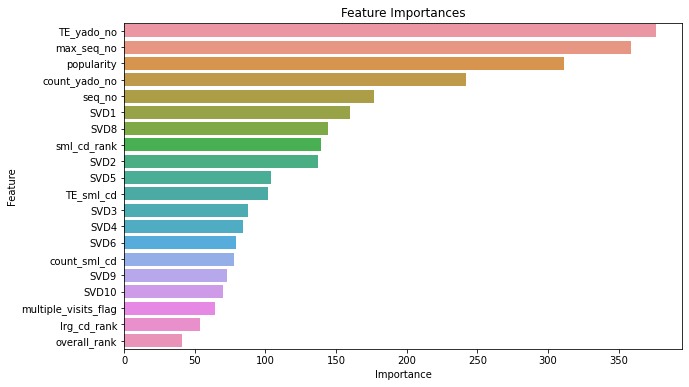

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df[:20])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [27]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.753549
1,000104bdffaaad1a1e0a9ebacf585f33,902,0.008117
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0.012058
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0.008135
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0.008263


In [28]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.013851
1,000007603d533d30453cc45d0f3d119f,2808,0.038707
2,000007603d533d30453cc45d0f3d119f,4101,0.010928
3,000007603d533d30453cc45d0f3d119f,5289,0.011570
4,000007603d533d30453cc45d0f3d119f,9187,0.000295


In [29]:
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.013851
1,000007603d533d30453cc45d0f3d119f,2808,0.038707
2,000007603d533d30453cc45d0f3d119f,4101,0.010928
3,000007603d533d30453cc45d0f3d119f,5289,0.011570
4,000007603d533d30453cc45d0f3d119f,9187,0.000295


In [30]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,11101,11134,7157,997,5821,12846,12837,8927,4391,1648
1,0000ca043ed437a1472c9d1d154eb49b,2570,8253,8140,13717,825,13682,3564,8677,13210,1678
2,0000d4835cf113316fe447e2f80ba1c8,9039,13642,918,2957,6722,7796,9854,6676,7509,7257
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,11715,9790,8355,7812,9438,6178,1924,755
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,12491,10915,11380,1908,1284,5490,902


In [20]:
# result_df.to_csv('../data/lgbBinary_ver3_result_df.csv', index=False)

In [31]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [32]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [23]:
y_true

array([[ 4101],
       [ 8253],
       [ 4863],
       ...,
       [13719],
       [10619],
       [ 2439]])

In [24]:
y_pred

array([[11101, 11134,  7157, ...,  8927,  4391,  1648],
       [ 2570,  8253,  8140, ..., 13682,  3564,  8677],
       [ 9039, 13642,   918, ...,  6676,  7509, 11031],
       ...,
       [12240,  6630,  7057, ...,  7308,  3650, 10155],
       [10619,   570, 12500, ..., 11091,  6933,  6595],
       [ 2439, 10415, 10095, ...,  3848,   846,  6579]])

In [33]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

In [34]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')


Map@10  0.38040379318774054


### 予測ファイルの作成

In [ ]:
#　testデータに結合
#　session_idとyado_noとtargetを結合
#  session_idごとにtargetの上位10件のyado_noを抽出を抽出し、画像のような横10列のデータセットに整形してください

In [27]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[0.89030224 0.00541336 0.00494273 ... 0.01289456 0.01673088 0.00809664]
8735000


In [28]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.890302
1,00001149e9c73985425197104712478c,4545,0.005413
2,00001149e9c73985425197104712478c,9534,0.004943
3,00001149e9c73985425197104712478c,6563,0.004134
4,00001149e9c73985425197104712478c,4420,0.005413


In [29]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [30]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.890302
1,00001149e9c73985425197104712478c,4545,0.005413
2,00001149e9c73985425197104712478c,9534,0.004943
3,00001149e9c73985425197104712478c,6563,0.004134
4,00001149e9c73985425197104712478c,4420,0.005413


In [31]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.890302
21,00001149e9c73985425197104712478c,9830,0.023018
27,00001149e9c73985425197104712478c,6766,0.018935
25,00001149e9c73985425197104712478c,2040,0.016090
10,00001149e9c73985425197104712478c,2680,0.015920
...,...,...,...
8734990,ffffe984aafd6127ce8e43e3ca40c79d,5508,0.002599
8734966,ffffe984aafd6127ce8e43e3ca40c79d,9168,0.000892
8734967,ffffe984aafd6127ce8e43e3ca40c79d,9190,0.000193
8734969,ffffe984aafd6127ce8e43e3ca40c79d,9183,0.000189


In [32]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,9830,6766,2040,2680,5466,11496,11561,10965,4948
1,0000e02747d749a52b7736dfa751e258,4066,6555,12862,143,11237,1266,7014,5267,11923,7913
2,0000f17ae2628237d78d3a38b009d3be,757,9910,410,2267,11001,6730,7710,6721,10485,10104
3,000174a6f7a569b84c5575760d2e9664,12341,277,2795,6991,5657,3359,10861,9319,7413,2047
4,00017e2a527901c9c41b1acef525d016,12029,5713,3844,9623,12524,6576,5372,13590,3187,6161


In [33]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [34]:
submit_df.to_csv('../data/lgbBinary_ver3_submit_df.csv', index=False)

In [46]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/lgbBinary_ver3.csv', index=False)